In [3]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    %run /Home/siv30/wad005/master/GRB/src/background_rates.ipynb
    %run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb

else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    %run /Users/andreas/phys/master/GRB/src/background_rates.ipynb
    %run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb


all UiB paths loaded

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!

all UiB paths loaded

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!

all UiB paths loaded
read_matlab_file.ipynb loaded successfully!

all UiB paths loaded
read_mat

In [4]:
def harvest_data(fn=None,T0=None):
    data = scipy.io.loadmat(path_m+fn)['out_data']
    df = pd.DataFrame(data=data)
    df.rename(columns={0:'year',1:'month',2:'day',3:'hour',4:'minute',5:'second',6:'erg',7:'dau',8:'det'},inplace=True)
    df = df.convert_dtypes()
    dt_column = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute', 'second']].astype(dtype=str))
    df['datetime'] = dt_column
    T0 = datetime.fromisoformat(T0)
    tus = df['datetime']-T0
    df['tus'] = tus
    df['tus'] = df['tus'].dt.total_seconds()
    df['dau'] = df['dau'].to_numpy()+1 #index starting now at 1
    df['det'] = df['det'].to_numpy()+1 #index starting now at 1
    df = make_adr(df)
    
    df.sort_values(by=['adr','tus'],inplace=True,ignore_index=True)
    print('dau/det starting from index 1')
    print('tus array given in seconds')
    return df
    
    tus,erg,dau,det = df['tus'].to_numpy(),df['erg'].to_numpy(),df['dau'].to_numpy(),df['det'].to_numpy()
    keV,abc = convert_erg(erg,dau,det,T0)
    df['keV'] = keV
    df['tus'] = df['tus'].to_numpy()*1e6

    st,dt = get_st(df),get_dt(df)
    df['st']=st
    df['dt']=dt

    flag = get_flag(df)
    df['flag']=flag
    print('safety time: ',np.round((len(np.where(flag==True)[0])/len(flag))*100,3), '% removed')
    df.drop(labels=np.where(flag==True)[0],inplace=True)
    df.sort_values(by='tus',inplace=True,ignore_index=True)
    df['tus'] = df['tus'].to_numpy()/1e6
    print('tus given in seconds')
    

In [12]:
df = harvest_data(fn='2021_12_11_13_10_1',T0='2021-12-11T13:10:01.323')
df.sort_values(by='tus',inplace=True,ignore_index=True)

dau/det starting from index 1
tus array given in seconds


tus array OK ...


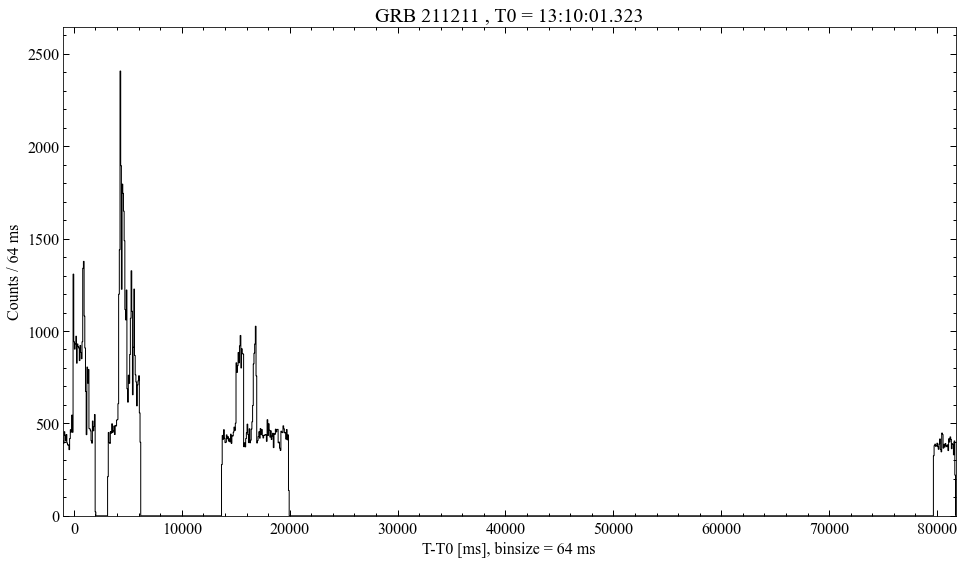

In [13]:
plot_HED(tus_arr=df['tus'].to_numpy()*1e6,binsize=64,T0=datetime.fromisoformat('2021-12-11T13:10:01.323'))

In [30]:
tus = df['tus'].to_numpy()
i_bkg_start = find_nearest(tus,17)
print(i_bkg_start)

102755


In [31]:
df_bkg = df.truncate(before=i_bkg_start,after=122713-1)
df_bkg

,year,month,day,hour,minute,second,erg,dau,det,datetime,tus,adr
102755,2021,12,11,13,10,18.323156,147,4,1,2021-12-11 13:10:18.323155944,17.000156,10
102756,2021,12,11,13,10,18.323202,406,2,2,2021-12-11 13:10:18.323202194,17.000202,5
102757,2021,12,11,13,10,18.323996,114,2,1,2021-12-11 13:10:18.323996167,17.000996,4
102758,2021,12,11,13,10,18.324331,284,2,3,2021-12-11 13:10:18.324330583,17.001331,6
102759,2021,12,11,13,10,18.324571,54,1,1,2021-12-11 13:10:18.324571222,17.001571,1
...,...,...,...,...,...,...,...,...,...,...,...,...
122708,2021,12,11,13,10,21.232175,58,4,2,2021-12-11 13:10:21.232175250,19.909175,11
122709,2021,12,11,13,10,21.232336,53,1,1,2021-12-11 13:10:21.232336389,19.909336,1
122710,2021,12,11,13,10,21.232338,1601,4,2,2021-12-11 13:10:21.232338139,19.909338,11
122711,2021,12,11,13,10,21.232338,336,4,3,2021-12-11 13:10:21.232338278,19.909338,12


tus array OK ...


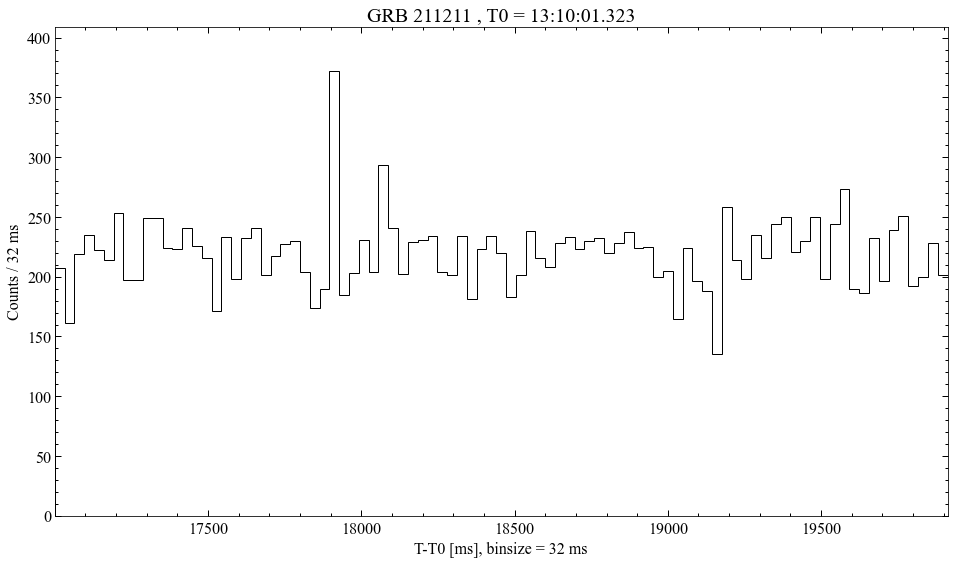

In [32]:
plot_HED(tus_arr=df_bkg['tus'].to_numpy()*1e6,binsize=32,T0=datetime.fromisoformat('2021-12-11T13:10:01.323'))

In [36]:
tus_bkg = df_bkg['tus'].to_numpy()
print('cr: ',len(tus_bkg)/(tus_bkg[-1]-tus_bkg[0]))
print('exposure: ',tus_bkg[-1]-tus_bkg[0])

cr:  6859.633887137611
exposure:  2.909484723000002


In [37]:
#cr depends heavily on selected timerange. from T0+17s to T0+20s is compliant with expected total count rate